# **Two Phase Predictions Design Pattern**

### ***Loading Libraries***

In [1]:
!pip install tensorflow-io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 12.5 MB/s eta 0:00:00


In [20]:
!pip install scipy

In [30]:
# Operating Systems
import os
import shutil
import pathlib
import argparse

# Hyperparameter Tuning
import hypertune

# Tools
from setuptools import setup
from setuptools import find_packages

# Numerical Computing
import numpy as np

# Data Manipuation
import pandas as pd

# SciPy
import scipy
from scipy import stats
from scipy import signal
from scipy.io import wavfile

# Data Visualization
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

# BigQuery
from google.cloud import bigquery
from google.colab import auth

# Scikit-Learn
from sklearn.utils import shuffle

from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer

# Extreme Gradient Boosting
import xgboost as xgb

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

# TensorFlow
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import Model
import tensorflow_datasets as tfds
from tensorflow_hub import KerasLayer
from tensorflow import feature_column as fc
from tensorflow.python.framework import dtypes
from tensorflow.keras.preprocessing import text
from tensorflow.keras.utils import to_categorical
from tensorflow_io.bigquery import BigQueryClient
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import callbacks, layers, models, utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Input, Flatten, Conv2D, MaxPooling2D

# Keras API
import kerastuner as kt

### ***Data pre-processing***

In [6]:
!gsutil cp gs://ml-design-patterns/audio-train.csv .

Copying gs://ml-design-patterns/audio-train.csv...
/ [1 files][228.4 KiB/228.4 KiB]                                                
Operation completed over 1 objects/228.4 KiB.                                    


In [7]:
label_data = pd.read_csv('audio-train.csv')
label_data.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [8]:
instrument_labels = ['Cello',
                     'Clarinet',
                     'Double_bass',
                     'Saxophone',
                     'Violin_or_fiddle',
                     'Snare_drum',
                     'Hi-hat',
                     'Flute',
                     'Bass_drum',
                     'Trumpet',
                     'Acoustic_guitar',
                     'Oboe',
                     'Gong',
                     'Tambourine',
                     'Cowbell',
                     'Harmonica',
                     'Electric_piano',
                     'Glockenspiel']

In [9]:
def check_instrument(row):
  if row['label'] in instrument_labels:
    return 1
  else:
    return 0

In [10]:
label_data['is_instrument'] = label_data.apply(check_instrument, axis=1)

In [11]:
label_data.head()

,fname,label,manually_verified,is_instrument
0,00044347.wav,Hi-hat,0,1
1,001ca53d.wav,Saxophone,1,1
2,002d256b.wav,Trumpet,0,1
3,0033e230.wav,Glockenspiel,1,1
4,00353774.wav,Cello,1,1


In [12]:
label_data['is_instrument'].value_counts()

is_instrument
0    4761
1    4712
Name: count, dtype: int64

In [13]:
verified = label_data.loc[label_data['manually_verified'] == 1]

In [16]:
verified['is_instrument'].value_counts()

is_instrument
1    2002
0    1708
Name: count, dtype: int64

In [17]:
verified.head()

,fname,label,manually_verified,is_instrument
1,001ca53d.wav,Saxophone,1,1
3,0033e230.wav,Glockenspiel,1,1
4,00353774.wav,Cello,1,1
6,003da8e5.wav,Knock,1,0
7,0048fd00.wav,Gunshot_or_gunfire,1,0


In [18]:
!gsutil cp gs://ml-design-patterns/audio_train/001ca53d.wav .

Copying gs://ml-design-patterns/audio_train/001ca53d.wav...
/ [1 files][888.9 KiB/888.9 KiB]                                                
Operation completed over 1 objects/888.9 KiB.                                    


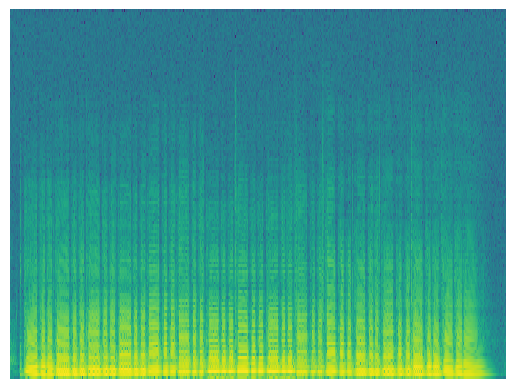

In [24]:
sample_rate, samples = wavfile.read('001ca53d.wav')

freq, times, spectro = signal.spectrogram(samples, sample_rate)

plt.figure()
fig = plt.gcf()
plt.axis('off')
plt.pcolormesh(times, freq, np.log(spectro))
plt.show()

In [25]:
!gsutil -m cp -r gs://ml-design-patterns/audio_train_spectro .

Copying gs://ml-design-patterns/audio_train_spectro/0033e230.png...
Copying gs://ml-design-patterns/audio_train_spectro/00353774.png...
Copying gs://ml-design-patterns/audio_train_spectro/001ca53d.png...
Copying gs://ml-design-patterns/audio_train_spectro/003da8e5.png...
Copying gs://ml-design-patterns/audio_train_spectro/0048fd00.png...
Copying gs://ml-design-patterns/audio_train_spectro/0091fc7f.png...
Copying gs://ml-design-patterns/audio_train_spectro/006f2f32.png...
Copying gs://ml-design-patterns/audio_train_spectro/0097160c.png...
Copying gs://ml-design-patterns/audio_train_spectro/00c934d7.png...
Copying gs://ml-design-patterns/audio_train_spectro/00cb787c.png...
Copying gs://ml-design-patterns/audio_train_spectro/00d3bba3.png...
Copying gs://ml-design-patterns/audio_train_spectro/00e2b4cd.png...
Copying gs://ml-design-patterns/audio_train_spectro/00f88dc5.png...
Copying gs://ml-design-patterns/audio_train_spectro/011a2185.png...
Copying gs://ml-design-patterns/audio_train_spec

## **Phase 1: Build The Offline-Optimized Binary Classification Model**

In [26]:
!mkdir audio_spectros
!mkdir audio_spectros/not_instrument
!mkdir audio_spectros/instrument

In [27]:
keys = verified['fname'].values
vals = verified['is_instrument'].values
label_lookup = dict(zip(keys, vals))

In [28]:
for i in os.listdir(os.getcwd() + '/audio_train_spectro'):
  id = i.split('.')[0] + '.wav'
  is_instra = label_lookup[id]
  im_path = os.getcwd() + '/audio_train_spectro/' + i
  if is_instra == 0:
    !mv $im_path audio_spectros/not_instrument/
  else:
    !mv $im_path audio_spectros/instrument/

In [31]:
data_dir = pathlib.Path(os.getcwd() + '/audio')

class_names = ['not_instrument', 'instrument']

In [32]:
BATCH_SIZE = 64

IMG_HEIGHT = 128

IMG_WIDTH = 128

STEPS_PER_EPOCH = np.ceil(3700/BATCH_SIZE)

In [33]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.1)

In [34]:
train_data_gen = image_generator.flow_from_directory(directory=data_dir,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = class_names,
                                                     class_mode='binary')

Found 0 images belonging to 2 classes.


In [35]:
val_data_gen = image_generator.flow_from_directory(directory=data_dir,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = class_names,
                                                     class_mode='binary',
                                                    subset='validation')

Found 0 images belonging to 2 classes.


In [36]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

0


In [37]:
instrument_modellabel_batch = next(train_data_gen)

In [38]:
val_image, val_label = next(val_data_gen)

In [39]:
mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=((128,128,3)),
    include_top=False,
    weights='imagenet'
)

9406464/9406464 [==============================] - 0s 0us/step


In [40]:
mobilenet.trainable = False

In [42]:
feature_batch = mobilenet(image_batch)

In [ ]:
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_avg = global_avg_layer(feature_batch)
print(feature_batch_avg.shape)

In [ ]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_avg)
print(prediction_batch.shape)

In [ ]:
model = tf.keras.Sequential([
  mobilenet,
  global_avg_layer,
  prediction_layer
])

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit_generator(train_data_gen,
                    validation_data=val_data_gen,
                    steps_per_epoch=STEPS_PER_EPOCH, epochs=10)

### ***TFLite & Quantize Model Conversion***

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()
open('converted_model.tflite', 'wb').write(tflite_model)

In [ ]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="converted_model.tflite")

interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()

output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']

input_data = np.array([val_image[0]], dtype=np.float32)

interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])

print(output_data)
print(val_label[0])

In [ ]:
input_details

## **Phase 2: Identifying Instrument Sounds**

In [ ]:
instrument_data = verified.loc[verified['is_instrument'] == 1]

In [ ]:
instrument_data.head()

In [ ]:
instrument_data['label'].value_counts()

In [ ]:
inst_keys = instrument_data['fname'].values
inst_vals = instrument_data['label'].values
instrument_label_lookup = dict(zip(inst_keys, inst_vals))

In [ ]:
!mkdir instruments

In [ ]:
for i in instrument_labels:
    path = os.getcwd() + '/instruments/' + i
    !mkdir $path

In [ ]:
for i in os.listdir(os.getcwd() + '/audio_train_spectro'):
    id = i.split('.')[0] + '.wav'
    try:
        instrument_name = instrument_label_lookup[id]
        im_path = os.getcwd() + '/audio_train_spectro/' + i
        new_path = os.getcwd() + '/instruments/' + instrument_name + '/' + i
        !mv $im_path $new_path
    except:
        pass

In [ ]:
instrument_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.1)

In [ ]:
BATCH_SIZE = 256

IMG_HEIGHT = 128

IMG_WIDTH = 128

STEPS_PER_EPOCH = np.ceil(2002/BATCH_SIZE)

In [ ]:
train_data_instrument = instrument_image_generator.flow_from_directory(directory=os.getcwd() + '/instruments',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = instrument_labels)

In [ ]:
val_data_instrument = instrument_image_generator.flow_from_directory(directory=os.getcwd() + '/instruments',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=False,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = instrument_labels,
                                                     subset='validation')

In [ ]:
image_instrument_train, label_instrument_train = next(train_data_instrument)

In [ ]:
image_instrument_val, label_instrument_val = next(val_data_instrument)

In [ ]:
vgg_model = tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=((128,128,3))
)

In [ ]:
vgg_model.trainable = False

In [ ]:
feature_batch = vgg_model(image_batch)

global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_avg = global_avg_layer(feature_batch)
print(feature_batch_avg.shape)

In [ ]:
prediction_layer = tf.keras.layers.Dense(len(instrument_labels), activation='softmax')

prediction_batch = prediction_layer(feature_batch_avg)
print(prediction_batch.shape)

In [ ]:
instrument_model = tf.keras.Sequential([
    vgg_model,
    global_avg_layer,
    prediction_layer
])

In [ ]:
instrument_model.summary()

In [ ]:
instrument_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
instrument_model.fit_generator(
    train_data_instrument,
    validation_data=val_data_instrument,
    steps_per_epoch=STEPS_PER_EPOCH, epochs=10)

### ***Getting Test Prediction on Instrument's Model***

In [ ]:
test_pred = instrument_model.predict(np.array([image_instrument_val[0]]))

In [ ]:
predicted_index = np.argmax(test_pred)
confidence = test_pred[0][predicted_index]

In [ ]:
test_pred[0]

In [ ]:
print('Predicted instrument: ', instrument_labels[predicted_index], round(confidence * 100), '% confidence')

print('Actual instrument: ', instrument_labels[np.argmax(label_instrument_val[0])])